# introduction

<p> <img style="float:right;margin:1px 2px 5px 1px; max-width:350px" src="https://user-images.githubusercontent.com/48359677/236228043-0f387056-1fcf-4789-9c5a-5c18f9d01b28.jpg"> In the era of business intelligence and analytics, even taxi drivers can benefit from a careful analysis of data to maximize their profits. Holding a "medallion" from the city's Taxi and Limousine Commission is a lucrative opportunity in New York City, as exemplified by the sale of one for over one million dollars. In this project, a random sample of 49999 New York taxi trips made in 2013 is analyzed using regression trees and random forests to predict the fares and tips based on location, date, and time. </p>

<p>This analysis aims to guide taxi drivers towards optimizing their profits.</p>

<p>Let's begin by exploring the data!</p>

# 1.Load libraries 

In [13]:
# install packages

install.packages("tidyverse")
install.packages("ggmap")
install.packages("viridis")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("randomForest")
install.packages("lubridate")

# Loading the packages
library(tidyverse)
library(ggmap)
library(viridis)
library(randomForest)
library(lubridate)
library(rpart)
library(rpart.plot)


Installing tidyverse [2.0.0] ...
	OK [linked cache]
Installing ggmap [3.0.2] ...
	OK [linked cache]
Installing viridis [0.6.3] ...
	OK [linked cache]
Installing rpart [4.1.19] ...
	OK [linked cache]
Installing rpart.plot [3.1.1] ...
	OK [linked cache]
Installing randomForest [4.7-1.1] ...
	OK [linked cache]
Installing lubridate [1.9.2] ...
	OK [linked cache]


# 2.Import Data

In [4]:
# Reading in the taxi data
taxi <- read_csv('datasets/taxi.csv')

# Taking a look at the first few rows in taxi
head(taxi, 10)
str(taxi)

Rows: 49999 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): medallion
dbl  (5): pickup_longitude, pickup_latitude, trip_time_in_secs, fare_amount,...
dttm (1): pickup_datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


medallion,pickup_datetime,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4D24F4D8EF35878595044A52B098DFD2,2013-01-13 10:23:00,-73.94646,40.77273,600,8.0,2.5
A49C37EB966E7B05E69523D1CB7BE303,2013-01-13 04:52:00,-73.99827,40.74041,840,18.0,0.0
1E4B72A8E623888F53A9693C364AC05A,2013-01-13 10:47:00,-73.95346,40.77586,60,3.5,0.7
F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13 11:14:00,-73.98137,40.72473,720,11.5,2.3
A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13 11:24:00,-73.96800,40.76000,240,6.5,0.0
19BF1BB516C4E992EA3FBAEDA73D6262,2013-01-13 10:51:00,-73.98502,40.76341,540,8.5,1.7
5F2EFC03B544635C9B0E7A4AA4FF9AC3,2013-01-13 12:53:00,-73.97295,40.79527,0,2.5,0.0
8DEB70907D00AA1D7FF5E2683240549B,2013-01-13 07:59:00,-73.96577,40.76530,120,4.0,0.0
E15F7CCB808DD15E0496D830D3DEDECE,2013-01-13 08:09:00,-73.94768,40.77507,720,14.0,2.0


spc_tbl_ [49,999 × 7] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ medallion        : chr [1:49999] "4D24F4D8EF35878595044A52B098DFD2" "A49C37EB966E7B05E69523D1CB7BE303" "1E4B72A8E623888F53A9693C364AC05A" "F7E4E9439C46B8AD5B16AB9F1B3279D7" ...
 $ pickup_datetime  : POSIXct[1:49999], format: "2013-01-13 10:23:00" "2013-01-13 04:52:00" ...
 $ pickup_longitude : num [1:49999] -73.9 -74 -74 -74 -74 ...
 $ pickup_latitude  : num [1:49999] 40.8 40.7 40.8 40.7 40.8 ...
 $ trip_time_in_secs: num [1:49999] 600 840 60 720 240 540 0 120 720 180 ...
 $ fare_amount      : num [1:49999] 8 18 3.5 11.5 6.5 8.5 2.5 4 14 4 ...
 $ tip_amount       : num [1:49999] 2.5 0 0.7 2.3 0 1.7 0 0 2 3 ...
 - attr(*, "spec")=
  .. cols(
  ..   medallion = col_character(),
  ..   pickup_datetime = col_datetime(format = ""),
  ..   pickup_longitude = col_double(),
  ..   pickup_latitude = col_double(),
  ..   trip_time_in_secs = col_double(),
  ..   fare_amount = col_double(),
  ..   tip_amount = col_double()
  .. )
 - 

## 2. Cleaning the taxi data
The taxi dataset provides information about the times and prices of numerous taxi trips, along with the longitude and latitude coordinates of the starting location. However, it is crucial to clean and preprocess the data before using it to build a model. This process may seem mundane, but it is a critical step that can mean the difference between a successful or failed model. Therefore, we need to perform some data cleaning on the taxi dataset to prepare it for further analysis.

In [6]:
# Renaming the location variables,
# dropping any journeys with zero fares and zero tips,
# and creating the total variable as the log sum of fare and tip
taxi <- taxi %>%
   rename(long = pickup_longitude, lat = pickup_latitude)  %>% 
   filter(fare_amount > 0 | tip_amount > 0) %>%
   mutate(total_amount = log(fare_amount + tip_amount) )

## 3. Zooming in on Manhattan
<p>While the dataset contains taxi trips from all over New York City, the bulk of the trips are to and from Manhattan, so let's focus only on trips initiated there.</p>

In [7]:
# Reducing the data to taxi trips starting in Manhattan
# Manhattan is bounded by the rectangle with 
# latitude from 40.70 to 40.83 and 
# longitude from -74.025 to -73.93
taxi <- taxi  %>% 
    filter(between(lat,  40.70, 40.83) & 
           between(long, -74.025, -73.93))

## 4. Where does the journey begin?
<p>It's time to draw a map! We're going to use the excellent <code>ggmap</code> package together with <code>ggplot2</code> to visualize where in Manhattan people tend to start their taxi journeys.</p>

Let's create a visualization to see where taxi journeys typically begin in Manhattan using the ggmap package in conjunction with ggplot2.

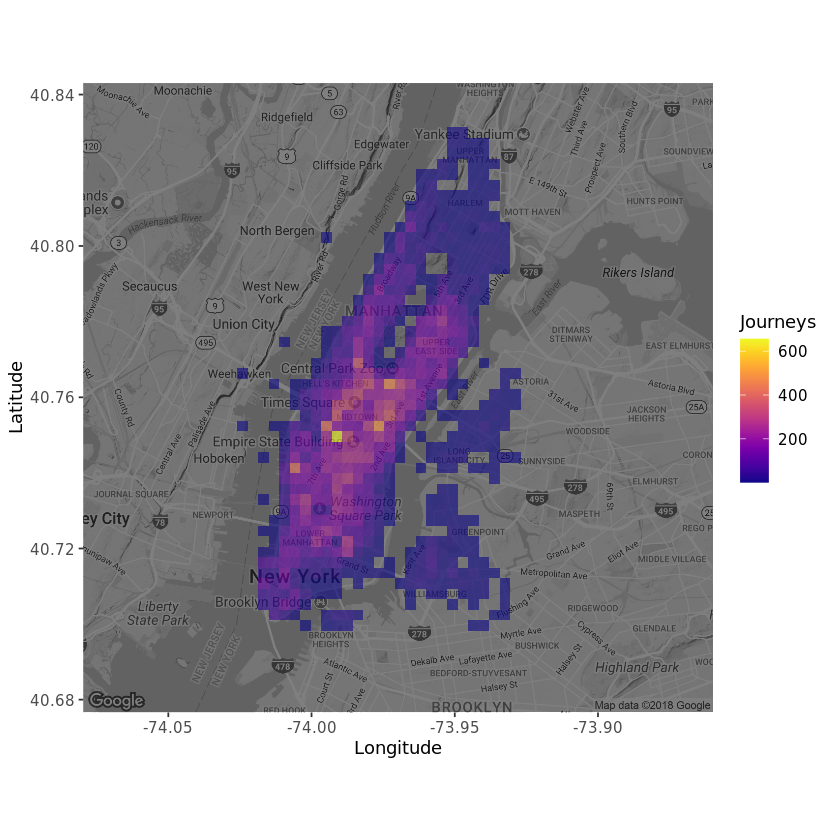

In [8]:
# Retrieving a stored map object which originally was created by
# nycmap <- get_map("manhattan", zoom = 12, color = "bw")
manhattan <- readRDS("datasets/manhattan.rds")

# Drawing a density map with the number of journey start locations
ggmap(manhattan, darken=0.5)+
    scale_fill_viridis(option='plasma') +
    geom_bin2d(data = taxi, aes(x = long, y = lat), bins = 60, alpha = 0.6) +
    labs(x = 'Longitude', y = 'Latitude', fill = 'Journeys')

## 5. Predicting taxi fares using a tree
The previous task's map revealed that the majority of taxi trips are concentrated in business and tourist areas, with some trips originating in Brooklyn. Although some trips were from Brooklyn, we can continue with our analysis.

Next, we will use a regression tree to predict the total fare using latitude and longitude as predictors. The algorithm will attempt to determine cutpoints in these predictors that result in the best predictive tree.

n= 45766 

node), split, n, deviance, yval
      * denotes terminal node

1) root 45766 14111.380 2.347548  
  2) lat>=40.72368 40815 12304.860 2.324730 *
  3) lat< 40.72368 4951  1610.088 2.535649 *

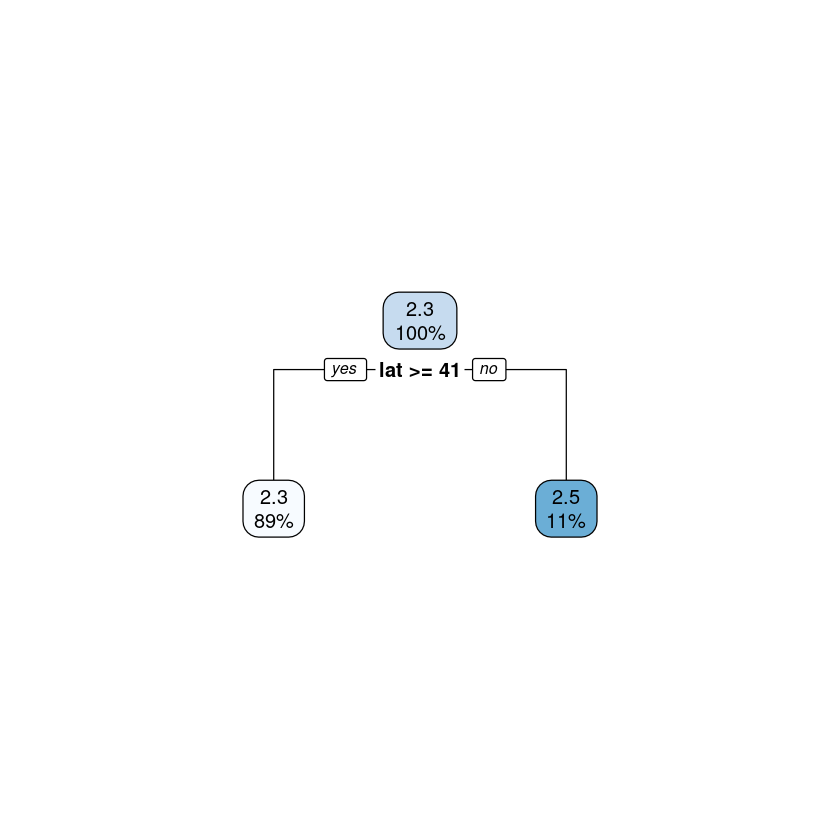

In [8]:
arbre = rpart(total_amount ~ lat + long, data = taxi)
arbre

rpart.plot(arbre)

## 6. It's time. More predictors.
The regression tree we generated in the previous step appears to be overly simplistic, with only one split based on latitude. Although it makes sense that trips originating from downtown Manhattan would be more expensive, it's clear that we need to include more predictors to improve our predictions. After all, any taxi driver investing in our data-driven insights would expect more than just one predictor. Therefore, let's explore adding additional predictors related to the time of day and day of the week the taxi trip was made.

In [9]:
# Loading in the lubridate package
library(lubridate)

# Generate the three new time variables
taxi <- taxi %>% 
    mutate(hour = hour(pickup_datetime),
           wday = wday(pickup_datetime, label = TRUE),
           month = month(pickup_datetime, label = TRUE))

## 7. More feature !
<p>Let's try fitting a new regression tree where we include the new time variables.</p>

In [14]:
# Fitting a tree to lat and long
fitted_tree <- rpart(total_amount ~ lat + long + hour + wday + month, data = taxi)

# Summarizing the performance of the tree
summary(fitted_tree)

Call:
rpart(formula = total_amount ~ lat + long + hour + wday + month, 
    data = taxi)
  n= 45766 

          CP nsplit rel error    xerror        xstd
1 0.01391974      0 1.0000000 1.0000516 0.007420033
2 0.01000000      1 0.9860803 0.9862678 0.007429606

Variable importance
 lat long 
  79   21 

Node number 1: 45766 observations,    complexity param=0.01391974
  mean=2.347548, MSE=0.3083376 
  left son=2 (40815 obs) right son=3 (4951 obs)
  Primary splits:
      lat   < 40.72368  to the right, improve=0.0139197400, (0 missing)
      long  < -74.00684 to the right, improve=0.0083103740, (0 missing)
      hour  < 5.5       to the right, improve=0.0033137510, (0 missing)
      month splits as  LLLLRRRRRRRR, improve=0.0016466420, (0 missing)
      wday  splits as  LLLRRRR, improve=0.0009349093, (0 missing)
  Surrogate splits:
      long < -74.00821 to the right, agree=0.92, adj=0.26, (0 split)

Node number 2: 40815 observations
  mean=2.32473, MSE=0.301479 

Node number 3: 4951 observ

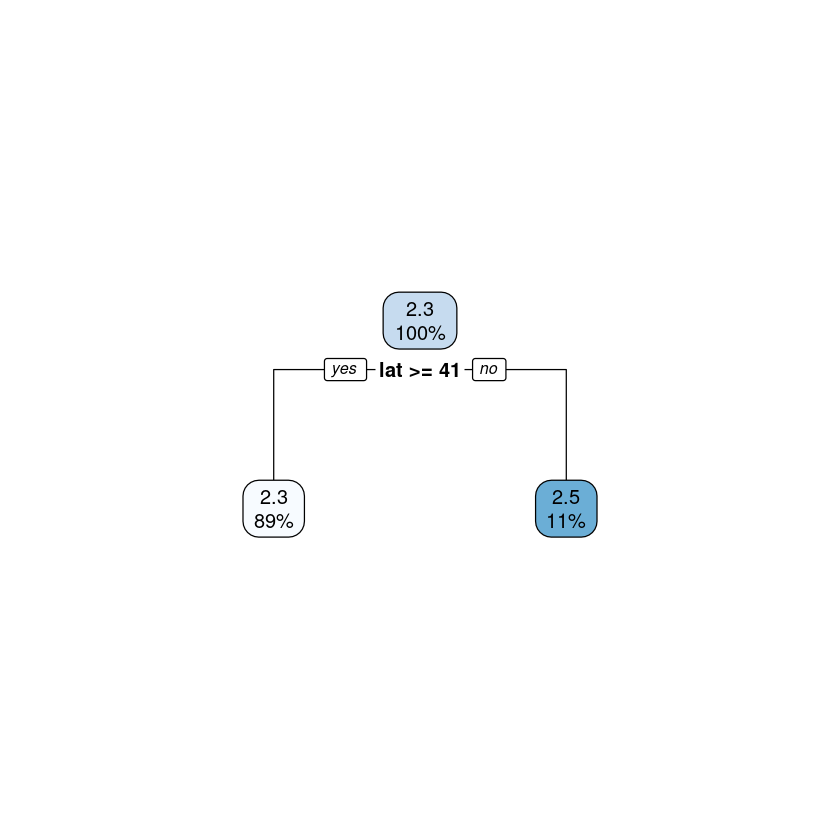

In [16]:
# draw a diagram of the tree structure
rpart.plot(fitted_tree)


## 8. One tree is not enough
The additional time variables did not significantly improve the regression tree's performance, as latitude remains the most informative variable for splitting the data. The other variables do not provide enough information to be included after the initial split. However, a random forest model that fits many trees to subsets of the data may include these variables in some of the trees and improve the model's overall performance.

In [18]:

# Fitting a random forest
fitted_forest <- randomForest(total_amount ~ lat + long + hour + wday + month,
    data=taxi, ntree=80, sampsize=10000)

# Printing the fitted_forest object
fitted_forest


Call:
 randomForest(formula = total_amount ~ lat + long + hour + wday +      month, data = taxi, ntree = 80, sampsize = 10000) 
               Type of random forest: regression
                     Number of trees: 80
No. of variables tried at each split: 1

          Mean of squared residuals: 0.2999105
                    % Var explained: 2.73

## 9. Plotting the predicted fare
In the output of fitted_forest, you can find the Mean of Squared Residuals, which represents the average squared error made by the model. If you scroll up and look at the summary of fitted_tree, you'll see the Residual Mean Deviance, which is the same value. If you compare these two numbers, you'll notice that fitted_forest has a slightly lower error. However, neither of the predictive models is particularly strong, as they only explain around 3% of the variance.

Next, we'll visualize the predictions made by fitted_forest on a map of Manhattan.

In [10]:
# Extracting the prediction from forest_fit
taxi$pred_total <- fitted_forest$predicted

# Plotting the predicted mean trip prices from according to the random forest
ggmap(manhattan, darken=0.5) +
    scale_fill_viridis(option = 'plasma') +
    stat_summary_2d(data=taxi, aes(x = long, y = lat, z = pred_total),
                    fun = mean, alpha = 0.6, bins = 60) +
    labs(x = 'Longitude', y = 'Latitude', fill = 'Log fare+tip')

ERROR: Error in ggmap(manhattan, darken = 0.5): object 'manhattan' not found


## 10. Plotting the actual fare
<p>Looking at the map with the predicted fares we see that fares in downtown Manhattan are predicted to be high, while midtown is lower. This map only shows the prediction as a function of <code>lat</code> and <code>long</code>, but we could also plot the predictions over time, or a combination of time and space, but we'll leave that for another time.</p>
<p>For now, let's compare the map with the predicted fares with a new map showing the mean fares according to the data.</p>

In [ ]:
# Function that returns the mean *if* there are 15 or more datapoints
mean_if_enough_data <- function(x) { 
    ifelse( length(x) >= 15, mean(x), NA) 
}

# Plotting the mean trip prices from the data
ggmap(manhattan, darken=0.5) +
    stat_summary_2d(data=taxi, aes(x = long, y = lat, z = total),
                    fun = mean_if_enough_data,
                    alpha = 0.6, bins = 60) +
  scale_fill_viridis(option = 'plasma') +
  labs(x = 'Longitude', y = 'Latitude', fill = 'Log fare+tip')

## 11. Where  do people spend the most?
<p>So it looks like the random forest model captured some of the patterns in our data. At this point in the analysis, there are many more things we could do that we haven't done. We could add more predictors if we have the data. We could try to fine-tune the parameters of <code>randomForest</code>. And we should definitely test the model on a hold-out test dataset. But for now, let's be happy with what we have achieved!</p>
<p>So, if you are a taxi driver in NYC, where in Manhattan would you expect people to spend the most on a taxi ride?</p>

In [ ]:
# Where are people spending the most on their taxi trips?
spends_most_on_trips <- "downtown" # "uptown" or "downtown"